In [1]:
import stream as st
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import anndata
import multiprocessing
import functools
import pathlib

from patsy import dmatrix
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as ss
import joblib
# from jksrlib.anndata.tools import grouped_obs_mean
from hba_data import internal_utils as hba_utils
from tqdm import tqdm

/home/qzeng_salk_edu/mambaforge/envs/hba/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## embedding data and gene data**

In [2]:
file_dict = {}

for i in pathlib.Path('./regional-axes-data/').glob('*.h5ad'):
    filepath = str(i)
    filename = str(i).split('/')[-1]
    region = '.'.join(filename.split('.')[0:2])
    file_dict[region] = filepath

In [3]:
file_dict.keys()

dict_keys(['L4_IT.CX', 'L23_IT.CX', 'Lamp5.CX', 'Pvalb_ChC.CX', 'Lamp5_LHX6.CX', 'Pvalb.CX_HIP', 'Sncg.CX_HIP', 'Sncg.CX', 'Pvalb_ChC.CX_HIP', 'Lamp5.CX_HIP', 'Lamp5_LHX6.CX_HIP', 'L5_IT.CX', 'L6_IT.CX', 'Sst.CX', 'Pvalb.CX', 'MSN_D2.BN_BF', 'MSN_D1.BN_BF', 'Vip.CX', 'Vip.CX_HIP', 'Foxp2.BN_BF', 'CHD7.BN_BF', 'Sst.CX_HIP'])

In [20]:
to_copy = ['Pvalb_ChC.CX_HIP','Lamp5_LHX6.CX_HIP','L5_IT.CX', 
           'L6_IT.CX', 'Sst.CX', 'Pvalb.CX',  'MSN_D1.BN_BF',
           'Vip.CX', 'Vip.CX_HIP', 'CHD7.BN_BF', 'Sst.CX_HIP' ]

In [4]:
# parameters
region = 'MSN_D1.BN_BF'
adata_fn = file_dict[region]
# genead_fn = '/gale/netapp/home/wtian/hba/dataset2/gene_mcds/sorted-nonnormalized/L4_IT.CHN.gene.h5ad'
#genead_fn = './test.h5ad'

ref_region = 'V1C'
n_neighbors = 15

temp folder, necessary but useless


In [6]:
!mkdir ./temp8-data
adata = anndata.read_h5ad(adata_fn)
adata.uns['workdir'] = './temp8-data/'

In [7]:
adata

AnnData object with n_obs × n_vars = 15768 × 6
    obs: 'PassFilter', 'Plate', 'mCCCFrac', 'mCGFrac', 'mCGFracAdj', 'mCHFrac', 'mCHFracAdj', 'FinalmCReads', 'pool', 'plate_relative_read', 'Donor', 'Region', 'MajorType', 'SubType', 'MajorType_umap_0', 'MajorType_umap_1', 'MajorType_tsne_0', 'MajorType_tsne_1', 'SubType_umap_0', 'SubType_umap_1', 'SubType_tsne_0', 'SubType_tsne_1', 'MajorType_version', 'SubType_version', 'CellClass', 'CellClass_version', 'SupRegion'
    uns: 'workdir'
    obsm: 'X_pca'

## check data have regional heterogeneity

<AxesSubplot:>

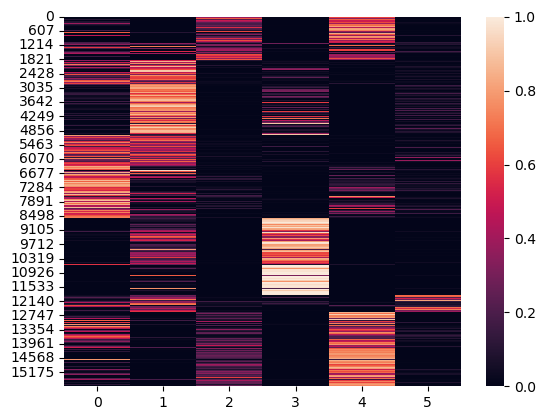

In [8]:
sns.heatmap(adata[adata.obs.sort_values('Region').index].X)

In [9]:
adata.obsm['var_genes'] = adata.obsm[f'X_pca']
adata.obsm['X_dr'] = adata.obsm['X_pca'].copy().values


**regional embedding and cell type regional identities**

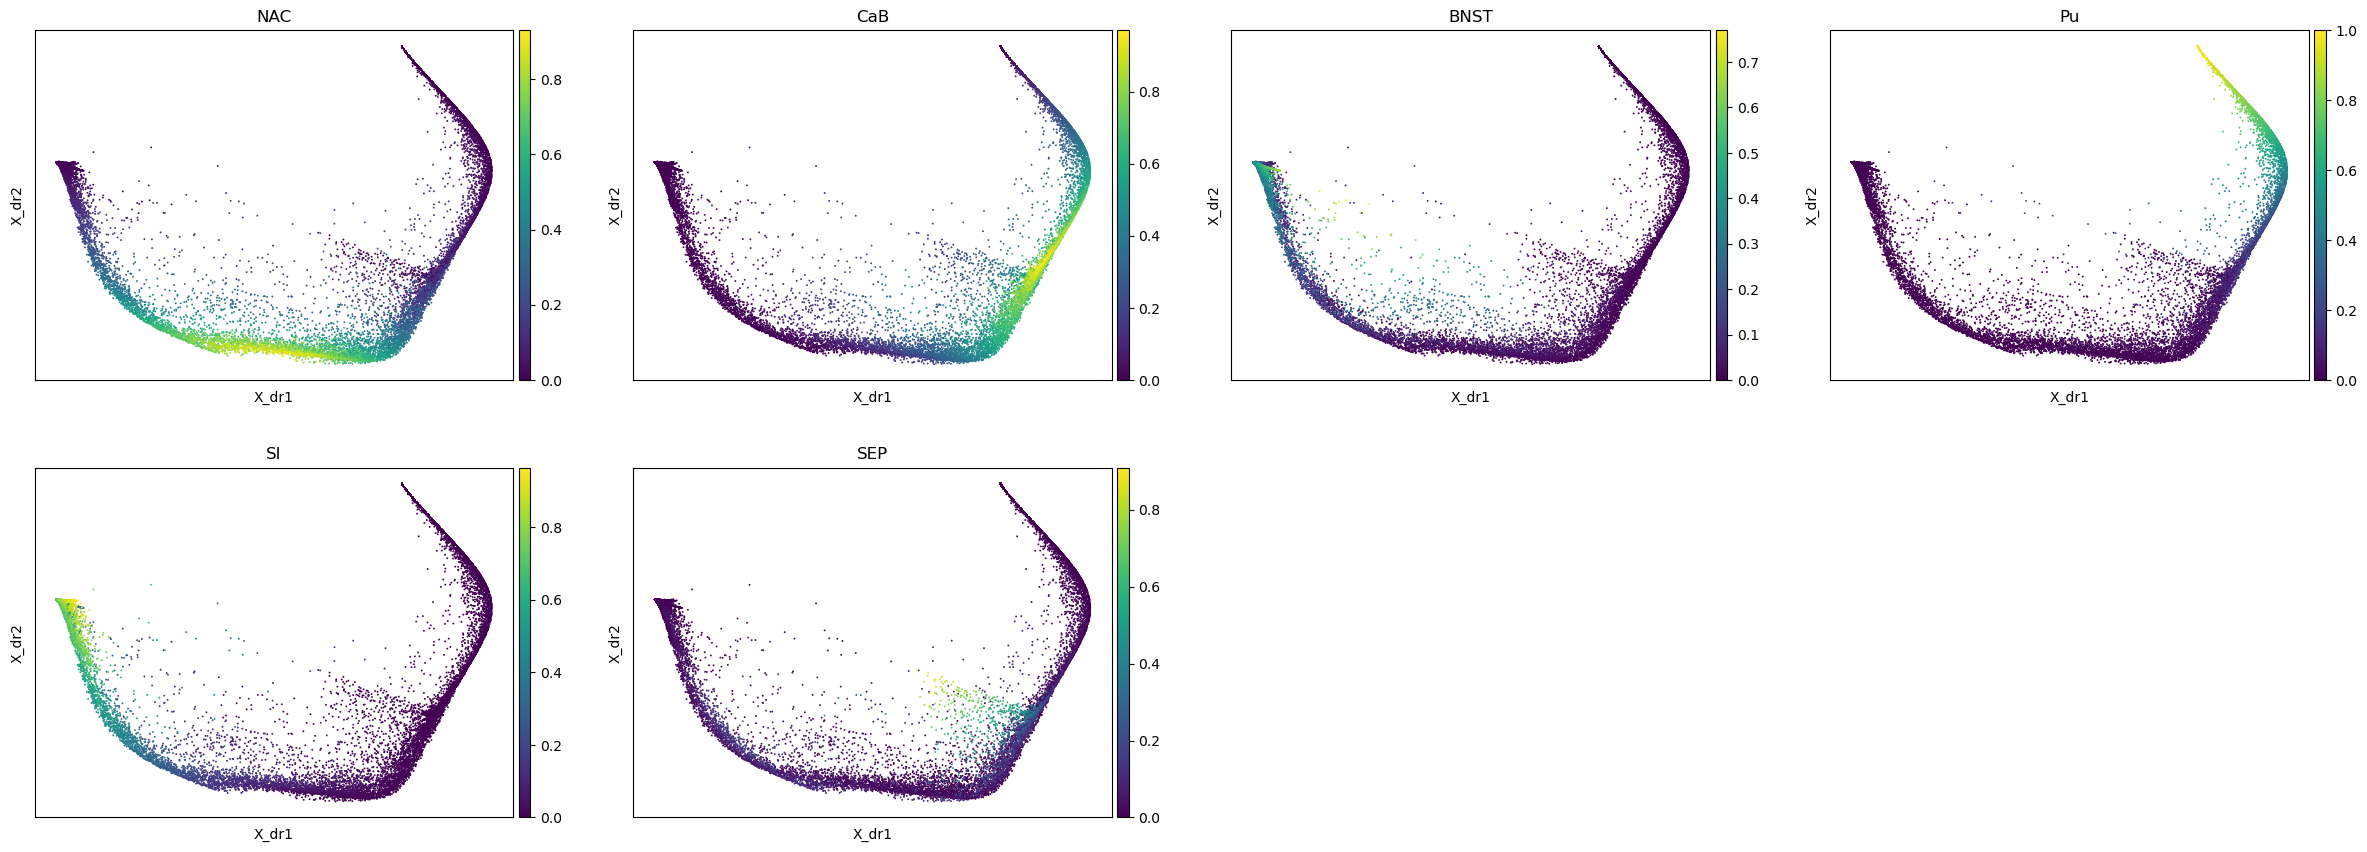

In [10]:
sc.pl.embedding(adata, basis='X_dr', 
                color=adata.var.index)

this provide initial starting points for principle tree construction

change `n_clusters` to get a good start.

the starting tree usually won't affect too much to the final one unless it's too off



Seeding initial elastic principal graph...
Clustering...
K-Means clustering ...
The number of initial nodes is 20
Calculatng minimum spanning tree...
Number of initial branches: 5


/home/qzeng_salk_edu/mambaforge/envs/hba/lib/python3.7/site-packages/stream/core.py:1548: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad)


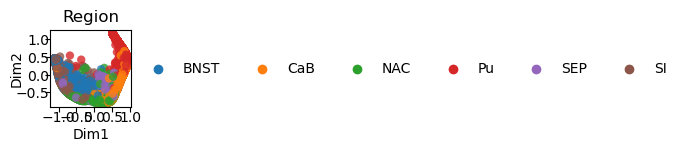

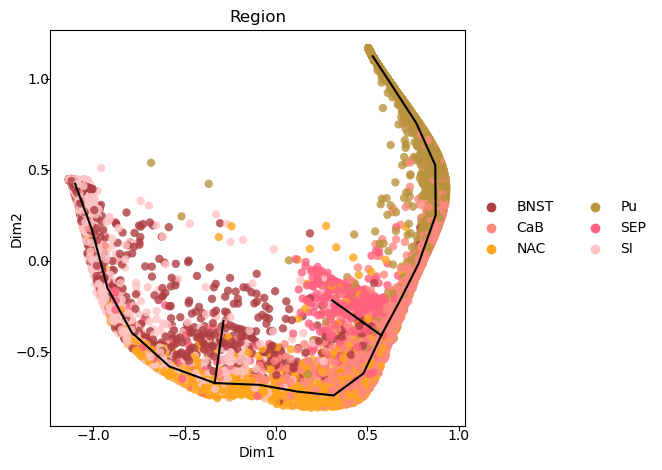

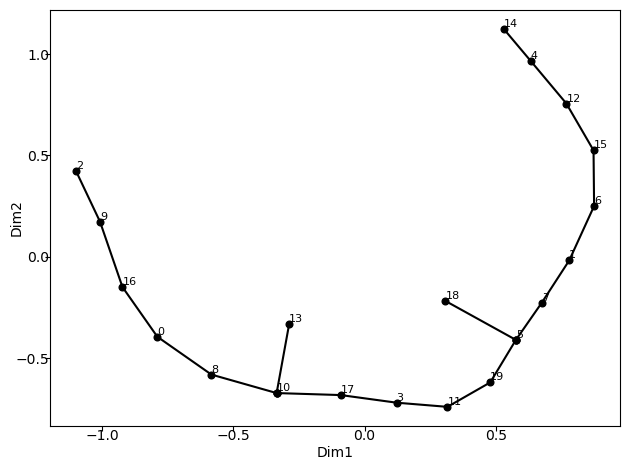

In [11]:
adata.obs['Region'] = adata.obs['Region'].astype('O')
st.seed_elastic_principal_graph(adata,n_clusters=20,n_neighbors=n_neighbors)
st.plot_dimension_reduction(adata,
                            color=['Region'], 
                            n_components=2, fig_size=(1,1),
                            show_graph=False, show_text=False, fig_legend_ncol=8)

reg_pal = hba_utils.Region.region_palette()
adata.uns['Region_color'] = {k:reg_pal[k] for k in adata.uns['Region_color']}

st.plot_dimension_reduction(adata,
                            color=['Region'], 
                            n_components=2,
                            show_graph=True, show_text=False, fig_legend_ncol=2)


st.plot_branches(adata,show_text=True)

**construct the final principle tree and compute pseudotime**

* epg_alpha: penalizes spurious branching events. The larger, the fewer branches the function will learn. (by default, epg_alpha=0.02)

* epg_mu: penalizes the deviation from harmonic embedding, where harmonicity assumes that each node is the mean of its neighbor nodes. The larger, the more edges the function will use to fit into points(cells) (by default, epg_mu=0.1)

* epg_lambda: penalizes the total length of edges. The larger, the 'shorter' curves the function will use to fit into points(cells) and the fewer points(cells) the curves will reach. (by default, epg_lambda=0.02)

* 'epg_trimmingradius' can help get rid of noisy points (by defalut epg_trimmingradius=Inf) e.g. st.elastic_principal_graph(adata,epg_trimmingradius=0.1)

In [12]:
# st.elastic_principal_graph(adata,epg_n_nodes=15, incr_n_nodes=15, 
#                            epg_alpha=0.01,epg_mu=0.05,epg_lambda=0.01)

def stream(epg_alpha=0.01, epg_mu=0.05, epg_lambda=0.02):
    st.elastic_principal_graph(adata,epg_n_nodes=10, incr_n_nodes=10, 
                               epg_alpha=epg_alpha,
                               epg_mu=epg_mu,
                               epg_lambda=epg_lambda,
    #                            epg_trimmingradius=20
                              )
    fig1 = st.plot_dimension_reduction(adata,color=['Region'],n_components=2,
                                show_graph=True,show_text=False, fig_legend_ncol=2)
    fig1 = st.plot_branches(adata,show_text=True)
    
    return fig1

In [15]:
test_dict = {'default':[0.02,0.1,0.02],
             # 'test1':[0.01, 0.05, 0.02],
             # 'test2':[0.01, 0.05, 0.001],
             # 'test3':[],
             # 'test4':[],
            }

default
epg_n_nodes is too small. It is corrected to the initial number of nodes plus incr_n_nodes
Learning elastic principal graph...
[1] "Constructing tree 1 of 1 / Subset 1 of 1"
[1] "Computing EPG with 30 nodes on 15768 points and 2 dimensions"
[1] "Using a single core"
Nodes = 20 21 22 23 24 25 26 27 28 29 
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD
0||30	0.01904	30	29	28	0	0	0	0.006864	0.005538	0.9923	0.9938	0.0115	0.0006784	0.02035	0.6105	0
8.611 sec elapsed
[[1]]

Number of branches after learning elastic principal graph: 1


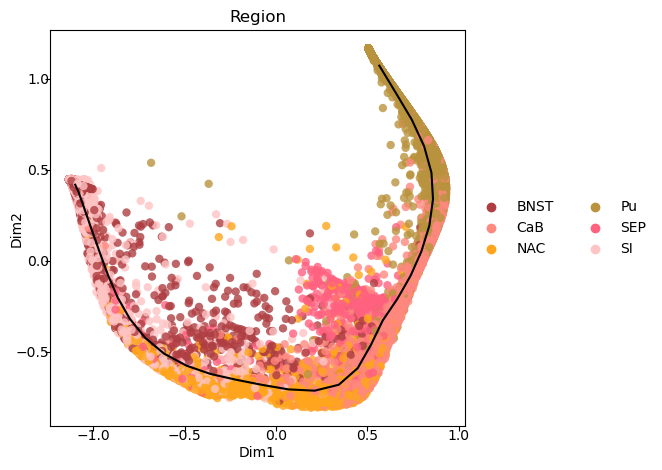

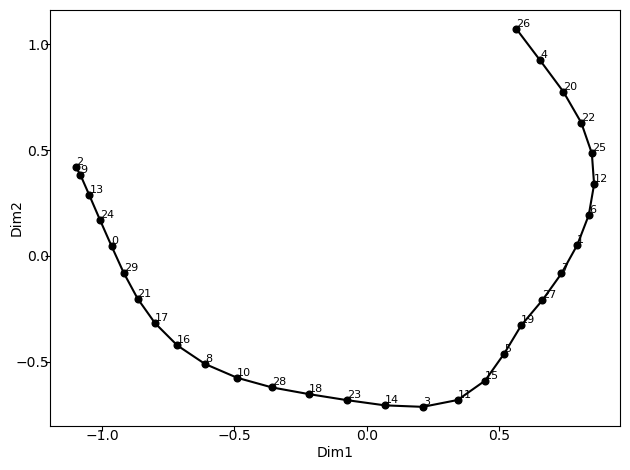

In [16]:
for name, para_list in test_dict.items():
    print(name)
    stream(epg_alpha=para_list[0], epg_mu=para_list[1], epg_lambda=para_list[2]) 

In [17]:
#src,tgt = 15,1
rlt = dict(adata=adata)
           #path=(src,tgt),)
           #genes=path_acc_genes)
joblib.dump(rlt, f'./adata/{region}.joblib')

['./adata/MSN_D1.BN_BF.joblib']

other methods to adjust the tree

usually not needed

In [ ]:
# tmpadata = adata.copy()
# st.prune_elastic_principal_graph(tmpadata,epg_collapse_mode='EdgesNumber',epg_collapse_par=2)
# st.plot_dimension_reduction(tmpadata,color=['Region'],n_components=2,show_graph=True,show_text=True)
## adata = tmpadata

In [ ]:
# tmpadata = adata.copy()
# st.optimize_branching(tmpadata,incr_n_nodes=30)
# st.plot_dimension_reduction(tmpadata,color=['Region'],n_components=2,show_graph=True,show_text=True)
## adata = tmpadata

In [ ]:
# tmpadata = adata.copy()
# st.shift_branching(tmpadata,epg_shift_mode='NodeDensity',epg_shift_radius=0.1,epg_shift_max=3)
# st.plot_dimension_reduction(tmpadata,color=['Region'],n_components=2,show_graph=True,show_text=True)
# # adata = tmpadata

**falten the tree for sanity checking**

In [ ]:
adata.obs['Region'] = adata.obs['Region'].astype('O')
st.plot_flat_tree(adata,color=['Region','branch_id_alias','S0_pseudotime',ref_region],
                  dist_scale=0.5,show_graph=True,show_text=True, fig_legend_ncol=2)

In [ ]:
adata.obs['Region'] = adata.obs['Region'].astype('O')
st.plot_flat_tree(adata,color=['Region','branch_id_alias','S0_pseudotime',ref_region,'LEC'],
                  dist_scale=0.5,show_graph=True,show_text=True, fig_legend_ncol=2)

**a class helps extract info from the principle tree**


In [ ]:

class PseudoGraph:
    def __init__(self, adata):
        self.adata = adata
        self.leaves = [x for x in adata.uns['flat_tree'].nodes() if adata.uns['flat_tree'].degree(x)==1]
        self.milestone_id_to_alias = nx.get_node_attributes(adata.uns['flat_tree'], 'label')
        self.milestone_alias_to_id = {v:k for k,v in nx.get_node_attributes(adata.uns['flat_tree'], 'label').items()}
        
    def cells_of_path(self, src, tgt):
        path_miles = nx.shortest_path(adata.uns['flat_tree'], src, tgt)

        path_ids = [adata.uns['flat_tree'].edges[e]['id'] \
                    for e in zip(path_miles, path_miles[1:])]

        orderdict = {s:i for i,s in enumerate(path_ids)}

        t_col = f'{self.milestone_id_to_alias[path_miles[0]]}_pseudotime'


        cells = adata.obs[adata.obs['branch_id'].isin(orderdict)].copy()
        cells = cells.sort_values(['branch_id', t_col], 
                                  key=lambda x: x.map(orderdict).fillna(x) )
#         cells = pd.concat((cells, adata.obs), axis=1)
        return cells[['branch_id', t_col, ]].copy()

    @staticmethod
    def binning(arr,nbins=50):
        return np.digitize(arr, np.linspace(min(arr), max(arr), nbins) ) 
    
    @staticmethod
    def plot_stream(psathdf, groupby, counton, smooth_sd=1):

        rcounts = pathdf.groupby(groupby)[counton].value_counts()
        rcounts.name = 'count'
        rcounts = rcounts.reset_index().pivot(index=groupby,columns=counton).fillna(0)
        rcounts.columns = rcounts.columns.droplevel()
        
        def gaussian_smooth(x, y, sd):
            weights = np.array([ss.norm.pdf(x, m, sd) for m in x])
            weights = weights / weights.sum(1)
            return (weights * y).sum(1)     

        smoothed = [gaussian_smooth(rcounts.index, y_, smooth_sd) for y_ in rcounts.T.values]
        smoothed = pd.DataFrame(np.array(smoothed), index=rcounts.columns, columns=rcounts.index).T
#         smoothed = np.array(smoothed)
        return rcounts, smoothed
        

gene data to use for test



In [ ]:
genead = anndata.read_h5ad(genead_fn)

In [ ]:
pg = PseudoGraph(adata)

**list all leave to leave path of the tree**

In [ ]:
for src,tgt in list(itertools.combinations(pg.leaves, 2)):
    print((src,tgt), (pg.milestone_id_to_alias[src],pg.milestone_id_to_alias[tgt]))

select one path to test

In [ ]:
src,tgt = 15,1

In [ ]:
pathdf = pg.cells_of_path(src,tgt)
t_col = pathdf.columns[-1]
tb_col = f'{t_col}_bin'
pathdf[tb_col] = pg.binning(pathdf[t_col])
pathdf['Region']=adata.obs['Region']


**plot regions along pseudotime**

In [ ]:
pathdf

In [ ]:
rcounts, smoothed = pg.plot_stream(pathdf, tb_col, 'Region', 2)

In [ ]:
plt.stackplot(smoothed.index, smoothed.T, baseline="sym", 
              colors=smoothed.columns.map(hba_utils.Region.region_palette()),
              labels=smoothed.columns
             )
# plt.legend(loc='lower center',ncol=8)
plt.gca().set_aspect(0.02)

In [ ]:
plt.figure(figsize=(10,3))
order = pathdf.groupby('Region')[t_col].mean().sort_values().index
sns.violinplot(data=pathdf, x='Region', y=t_col, 
               cut=0, order=order, 
               palette=hba_utils.Region.region_palette(),
               scale='width', saturation=0.5, inner=None
              )
sns.stripplot(data=pathdf, x='Region', y=t_col, 
              order=order, size=0.5,
#                palette=hba_utils.Region.region_palette(),
              palette=['k']
             )

cell x gene within this path

In [ ]:
genedf = genead[pathdf.index]
genedf = genedf.to_df()
# genedf = genedf.loc[:,~genedf.columns.duplicated(keep=False)]

In [ ]:
def fit_gene_to_path(gene, genedf, pathdf, t_col,
                       return_stats=False, return_model=False):
    knots = pathdf.groupby('branch_id').agg({t_col:['max', 'min']})
    knots = (knots.iloc[:-1,0].values + knots.iloc[1:,1].values)/2
    
#     X = dmatrix(f"bs(train, knots=({','.join(knots.astype(str))},), degree=3, include_intercept=False)", 
#                 {"train": pathdf[t_col]}, return_type='dataframe')
    X = dmatrix(f"cr(train, df=3,)", 
                {"train": pathdf[t_col]}, return_type='dataframe')
    Y = genedf.loc[pathdf.index, gene]

    corr = np.corrcoef(pathdf[t_col],Y)[0,1]
    
    cubspline = sm.GLM(Y, X).fit()

    pval = ss.chi2.sf(cubspline.pearson_chi2, cubspline.df_model)
    
    
    rtn = [cubspline.pearson_chi2] if return_stats else [pval]
    rtn += [corr]
    if return_model:
        rtn += [cubspline]

    return rtn

In [ ]:
worker = functools.partial(fit_gene_to_path, genedf=genedf, pathdf=pathdf, t_col=t_col)

In [ ]:
colours.sort(key=lambda rgb: colorsys.rgb_to_hsv(*rgb)    )

In [ ]:
path_acc_genes = list(map(worker, tqdm(genedf.columns)))

path_acc_genes = pd.DataFrame(path_acc_genes, index=genedf.columns, columns=['pval','pearson'])

path_acc_genes['-log10p'] = -np.log10(path_acc_genes['pval'])

In [ ]:
palettedf['CrtRegionColor'].value_counts()

**save data**

for further analysis

In [ ]:
rlt = dict(adata=adata, 
           path=(src,tgt),
           genes=path_acc_genes)

In [ ]:
joblib.dump(rlt, 'test.regional-axes-genes.joblib')

In [ ]:
path_acc_genes['abs_rho'] = path_acc_genes['pearson'].abs()

In [ ]:
sns.jointplot(data=path_acc_genes,x='-log10p',y='pearson',kind='hex',gridsize=50)

In [ ]:
genedf[tb_col] = pathdf[tb_col]

genedf['Region'] = pathdf['Region']

meandf1 = genedf.groupby(tb_col).mean()
meandf2 = genedf.groupby('Region').mean()

In [ ]:
sns.clustermap(meandf2[path_acc_genes[path_acc_genes['abs_rho']>0.4].index].loc[order], row_cluster=False)

In [ ]:
sns.clustermap(meandf1[path_acc_genes[path_acc_genes['abs_rho']>0.5].index], row_cluster=False)

In [ ]:
sns.clustermap(genedf[path_acc_genes[path_acc_genes['abs_rho']>0.5].index], vmax=0.2, row_cluster=False)

In [ ]:
sns.clustermap(genedf[path_acc_genes[path_acc_genes['pval']<0.0001].index], vmax=0.2, row_cluster=False)

In [ ]:
path_acc_genes